In [62]:
# snapcam.py
import os
import cv2
import time
import threading
from typing import Optional

class SnapCam:
    """
    RTSP를 백그라운드로 읽어 최신 프레임만 유지하고,
    shoot() 호출 시 '딱 1장'을 즉시(또는 짧은 대기 후) 반환하는 클래스.

    사용 예) (주피터)
    -------------------
    cam = SnapCam("rtsp://210.99.70.120:1935/live/cctv001.stream", max_width=960).start()
    # 첫 프레임 예열 대기(선택): cam.wait_ready(2.0)

    frame = cam.shoot(timeout=1.0)  # BGR
    from matplotlib import pyplot as plt
    import cv2 as _cv2
    if frame is not None:
        plt.imshow(_cv2.cvtColor(frame, _cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

    cam.stop()
    """

    def __init__(self,
                 url: str,
                 max_width: int = 0,
                 transport: str = "tcp",      # "tcp" or "udp"
                 socket_timeout_s: float = 2.0,
                 analyze_bytes: int = 32000,
                 probe_duration_s: float = 0.0,
                 reopen_delay_s: float = 0.5):
        self.url = url
        self.max_width = max_width
        self.transport = transport
        self.socket_timeout_s = socket_timeout_s
        self.analyze_bytes = analyze_bytes
        self.probe_duration_s = probe_duration_s
        self.reopen_delay_s = reopen_delay_s

        self._cap: Optional[cv2.VideoCapture] = None
        self._t: Optional[threading.Thread] = None
        self._stop = threading.Event()
        self._ready = threading.Event()
        self._lock = threading.Lock()
        self._latest = None          # 최신 BGR 프레임
        self._latest_ts = 0.0

    # ---------- public API ----------
    def start(self):
        """백그라운드 리더 시작 (이미 시작돼 있으면 무시)"""
        if self._t and self._t.is_alive():
            return self
        self._stop.clear()
        self._ready.clear()
        self._t = threading.Thread(target=self._run, name="SnapCamReader", daemon=True)
        self._t.start()
        return self

    def stop(self):
        """리더 정지 및 리소스 해제"""
        self._stop.set()
        if self._t:
            self._t.join(timeout=2.0)
        self._t = None
        self._release_cap()

    def wait_ready(self, timeout: float = 2.0) -> bool:
        """최초 유효 프레임이 들어올 때까지 대기"""
        return self._ready.wait(timeout=timeout)

    def shoot(self, wait: bool = False, timeout: float = 0.5):
        """
        최신 프레임 1장을 반환(BGR). 프레임 없으면 None.
        - wait=True면 지정한 timeout까지 첫 프레임 대기
        """
        if wait and not self._ready.is_set():
            self._ready.wait(timeout=timeout)
        with self._lock:
            if self._latest is None:
                return None
            # 복사 비용을 줄이고 싶으면 그대로 반환해도 되지만,
            # 호출자가 수정할 수 있으니 안전하게 copy().
            return self._latest.copy()

    def last_timestamp(self) -> float:
        """마지막 프레임 수신 시각(epoch seconds)"""
        return self._latest_ts

    # 컨텍스트 매니저
    def __enter__(self):
        return self.start()

    def __exit__(self, exc_type, exc, tb):
        self.stop()

    # ---------- internal ----------
    def _set_ffmpeg_env(self):
        # OpenCV FFmpeg 백엔드 저지연 옵션 구성
        # 형식: "k;v|k;v|..."
        opts = []
        opts.append(f"rtsp_transport;{self.transport}")
        # microseconds 단위
        stimeout_us = int(self.socket_timeout_s * 1_000_000)
        opts.append(f"stimeout;{stimeout_us}")
        opts += [
            "fflags;nobuffer",
            "flags;low_delay",
            "reorder_queue_size;0",
            f"probesize;{self.analyze_bytes}",
            f"analyzeduration;{int(self.probe_duration_s * 1_000_000)}",
            "max_delay;0",
            "buffer_size;102400",
        ]
        os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "|".join(opts)

    def _open_cap(self) -> Optional[cv2.VideoCapture]:
        self._set_ffmpeg_env()
        cap = cv2.VideoCapture(self.url, cv2.CAP_FFMPEG)
        if not cap.isOpened():
            return None
        # 프레임 큐를 작게 → 최신 프레임만
        cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        return cap

    def _release_cap(self):
        if self._cap is not None:
            try:
                self._cap.release()
            except Exception:
                pass
        self._cap = None

    def _maybe_resize(self, img):
        if not self.max_width or self.max_width <= 0:
            return img
        h, w = img.shape[:2]
        if w <= self.max_width:
            return img
        scale = self.max_width / float(w)
        return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LINEAR)

    def _run(self):
        self._cap = self._open_cap()
        last_fail = 0
        while not self._stop.is_set():
            if self._cap is None:
                # 재연결
                time.sleep(self.reopen_delay_s)
                self._cap = self._open_cap()
                continue

            ok, frame = self._cap.read()
            if not ok or frame is None or frame.size == 0:
                # 연속 실패 시 재연결
                last_fail += 1
                if last_fail > 30:
                    self._release_cap()
                    last_fail = 0
                    time.sleep(self.reopen_delay_s)
                else:
                    time.sleep(0.005)
                continue

            last_fail = 0
            frame = self._maybe_resize(frame)
            with self._lock:
                self._latest = frame
                self._latest_ts = time.time()
                # 최초 프레임 도착 시 ready 세트
                if not self._ready.is_set():
                    self._ready.set()
        # 종료
        self._release_cap()


In [63]:
import cv2
from matplotlib import pyplot as plt

cam = SnapCam("rtsp://210.99.70.120:1935/live/cctv001.stream", max_width=960).start()
cam.wait_ready(2.0)  # 선택: 최초 프레임 최대 2초 대기


False

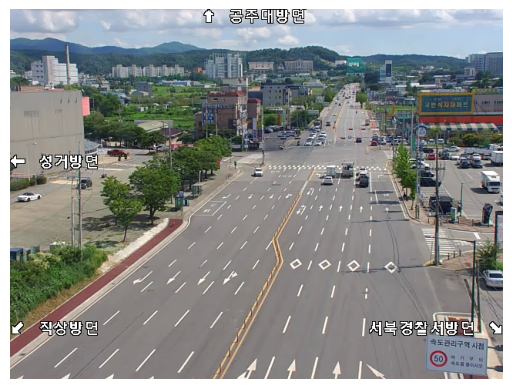

In [64]:
frame = cam.shoot(wait=True, timeout=1.0)  # 최신 1장
if frame is None:
    print("프레임 실패")
else:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

In [ ]:
#cam.stop()